# Practice Session 09: Forecasting


Author: <font color="blue">Leticia Martín Cabrera</font>

E-mail: <font color="blue">leticia.martin03@estudiant.upf.edu</font>

Date: <font color="blue">29/11/2021</font>

In [1]:
import io
import csv
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# 1. Dataset

In [2]:
# Leave this cell as-is

INPUT_FILE = "data/aemet-barcelona-airport-2016-2021.csv"
weather = pd.read_csv(INPUT_FILE, sep=",")

In [3]:
# Leave this cell as-is

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "time_temp_min",
  "horatmax" : "time_temp_max",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "time_windspeed_gusts",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "time_pressure_max",
  "presMin" : "pressure_min",
  "horaPresMin" : "time_pressure_min"
}

In [4]:
#Rename column names
weather= weather.rename(columns=COLUMN_NAMES)

#print the first 3 rows of the data
weather.head(3)

,date,station_num,station_name,station_province,station_altitude,temp_avg,rainfall,temp_min,time_temp_min,temp_max,time_temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,time_windspeed_gusts,sun,pressure_max,time_pressure_max,pressure_min,time_pressure_min
0,2016-09-01,76,BARCELONA AEROPUERTO,BARCELONA,4,"27,2","0,0","22,9",03:30,"31,5",09:32,24.0,"4,2","8,3",13:52,"10,0","1021,9",Varias,"1020,1",17
1,2016-09-02,76,BARCELONA AEROPUERTO,BARCELONA,4,"25,7","0,0","22,2",Varias,"29,2",13:24,23.0,"5,3","11,7",11:45,"9,9","1021,3",Varias,"1018,0",17
2,2016-09-03,76,BARCELONA AEROPUERTO,BARCELONA,4,"26,2","0,0","22,9",05:27,"29,6",12:02,24.0,"5,8","12,8",13:13,"10,1","1020,0",00,"1017,0",16


In [5]:
#list of column names to drop 
COLUMNS_DROP = ['station_num', 'station_name', 'station_province', 'station_altitude']

#adding to the list the columns of time
for column_name in list(COLUMN_NAMES.values()):
    if 'time_' in column_name:
        COLUMNS_DROP.append(column_name)
        
#Deleting the colums which we will not use        
weather = weather.drop(COLUMNS_DROP, axis= 1)
#print the first 3 rows of the data
weather.head(3)

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
0,2016-09-01,"27,2","0,0","22,9","31,5",24.0,"4,2","8,3","10,0","1021,9","1020,1"
1,2016-09-02,"25,7","0,0","22,2","29,2",23.0,"5,3","11,7","9,9","1021,3","1018,0"
2,2016-09-03,"26,2","0,0","22,9","29,6",24.0,"5,8","12,8","10,1","1020,0","1017,0"


In [6]:
#Create a function str_commas_to_float
def str_commas_to_float(x):
    
    #return nan value
    if x != x:
        return np.nan
    #return float number
    elif type(x) == float:
        return x
    #convert number with commas into floating point numbers
    elif ',' in x:
        return float(x.replace(',','.'))
    #change Ip to 0.0
    elif x == 'Ip':
        return 0.0
    else:
        return np.nan

In [7]:
# Test the function str_commas_to_floats

def test_str_commas_to_floats(x):
    print("%s -> %.4f" % (x, str_commas_to_float(x)))

# Should be not a number
test_str_commas_to_floats("")

# Should be 0.0
test_str_commas_to_floats("0,0")

# Should be not a number
test_str_commas_to_floats("05:27")

# Should be 22.9
test_str_commas_to_floats("22,9")

# Should be 0.0
test_str_commas_to_floats("Ip")

# Should be not a number
test_str_commas_to_floats("Varias")



 -> nan
0,0 -> 0.0000
05:27 -> nan
22,9 -> 22.9000
Ip -> 0.0000
Varias -> nan


In [8]:
#Applying the avobe function to some columns
COLUMNS = ['temp_min', 'temp_max', 'temp_avg', 'rainfall', 'windspeed_dir', 'windspeed_avg', 'windspeed_gusts', 'sun', 'pressure_min', 'pressure_max']
for column in COLUMNS:
    new_column = []
    for x in weather[column]:
        new_column.append(str_commas_to_float(x))
    weather[column] = new_column

In [9]:
#Index the data by date

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
weather.head(3)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-09-01,27.2,0.0,22.9,31.5,24.0,4.2,8.3,10.0,1021.9,1020.1
2016-09-02,25.7,0.0,22.2,29.2,23.0,5.3,11.7,9.9,1021.3,1018.0
2016-09-03,26.2,0.0,22.9,29.6,24.0,5.8,12.8,10.1,1020.0,1017.0


In [10]:
# Leave this code as-is

# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

In [11]:
# Leave this code as-is

# Plot function
def plot(df, column, xlabel='Date', ylabel=''):
    
    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[column],
                  fmt='.-', color='black')

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def plot_min_avg_max(df, min_column='temp_min', avg_column='temp_avg', max_column='temp_max', xlabel='Date', ylabel='Daily temperature [C]'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[avg_column],
                  fmt='.-', color='black', label='Average')
    plt.fill_between(df.index, df[min_column], df[max_column],
                     color='lightgray')
    plt.legend()

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

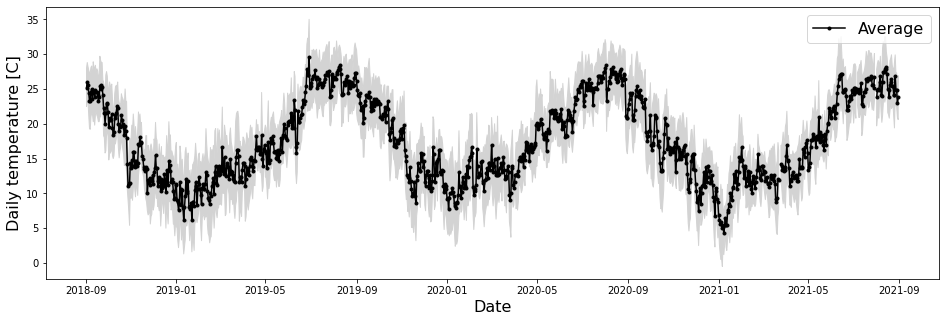

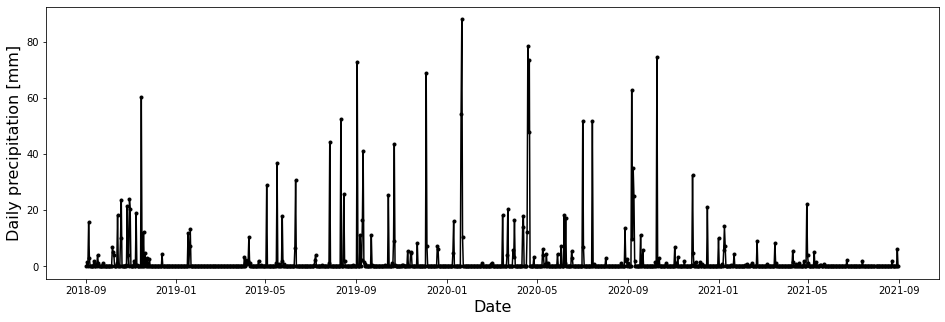

In [12]:
# Leave this code as-is

# Retrieve the last three years
weather_sample = weather.tail(3*365)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Daily precipitation [mm]")

We can differenciate in the plot of temperature the 4 seasons where there is a peak of high temperatures in july and august ( summer) and another peak of low temperatures in January and February (winter).Moreover, we ca observe in the plot ,between the temperature of summer and winter, how in the months from September to January the temperatures decrease (Autumn) and from  January to May the temperature increase (spring). 

In the plot of precipitation is more difficult differenciate the 4 seasons since the values are more random and it does not seem to follow any pattern.

## 1.1 Smooth the series using moving averages

In [13]:
#Create the function moving_average
def moving_average(df, window_size):

    smoothed = pd.DataFrame(columns=df.columns)

    for i in range(len(df)):
                
        if i < window_size:
            indx = i
        else:
            indx = window_size
        
        #Obtain the averages of the columns of the window
        smoothed.loc[i] = df.iloc[i-indx:i+1].mean()

    smoothed.set_index(df.index, inplace=True)

    return smoothed

In [14]:
# Leave this code as-is

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-09-01,27.200000,0.0000,22.900000,31.500000,24.000000,4.200000,8.300000,10.000000,1021.900000,1020.100000
2016-09-02,26.450000,0.0000,22.550000,30.350000,23.500000,4.750000,10.000000,9.950000,1021.600000,1019.050000
2016-09-03,26.366667,0.0000,22.666667,30.100000,23.666667,5.100000,10.933333,10.000000,1021.066667,1018.366667
2016-09-04,26.400000,0.0000,22.725000,30.100000,42.500000,4.925000,10.900000,9.550000,1020.375000,1017.800000
2016-09-05,26.700000,0.0000,23.020000,30.400000,37.800000,4.560000,10.060000,9.740000,1020.060000,1017.620000
2016-09-06,26.783333,0.0000,23.050000,30.533333,48.000000,4.500000,9.683333,9.866667,1019.783333,1017.266667
2016-09-07,26.671429,0.0000,23.014286,30.328571,42.571429,4.414286,9.771429,9.985714,1019.414286,1016.957143
2016-09-08,26.462500,0.0000,22.875000,30.050000,38.750000,4.350000,9.587500,9.675000,1019.037500,1016.625000
2016-09-09,26.412500,0.0375,23.000000,29.812500,38.750000,4.450000,9.900000,9.287500,1018.287500,1015.737500


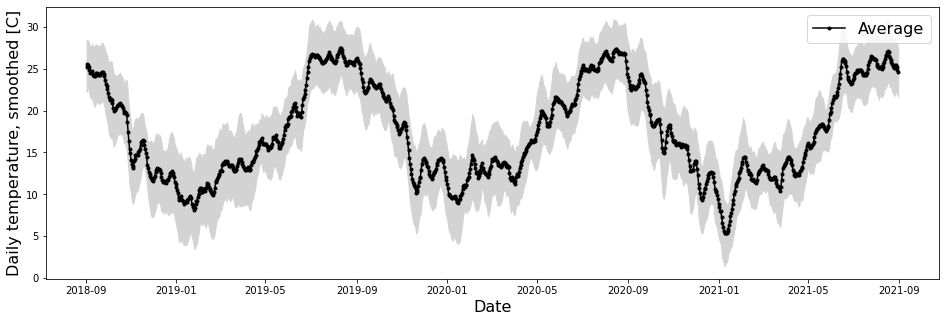

In [15]:
# Leave this code as-is

# Sample last 3 years
weather_smoothed_sample = weather_smoothed.tail(3*365)

plot_min_avg_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]')

One of the key difficulties is dealing with the beginning of the series since there are no values available before the first data point. To correct this, reduce the size of the window for the first problematic days.

In [16]:
#create a separate test dataset and smooths this test dataset 20 times
weather_test = weather
for i in range(20): 
    moving_average(weather_test, window_size)


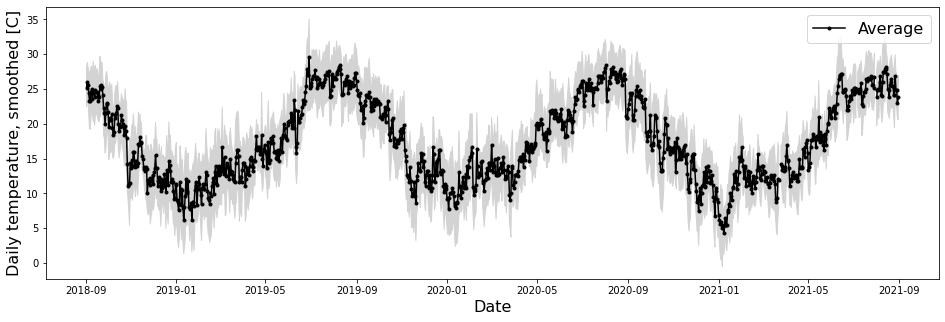

In [17]:
#Plot the daily temperature 
weather_smoothed_test = weather_test.tail(3*365)

plot_min_avg_max(weather_smoothed_test, ylabel='Daily temperature, smoothed [C]')

## 1.2. Smooth the series by binning per floating weeks

In [18]:
#Create a funtion list_of_floating_week_starts
def list_of_floating_week_starts(first, last):
    weeks = []

    # Adding the first element in the list
    weeks.append(first)
    
    #Create a variable which 
    date = first
    
    #we check if the current week is earlier than the last day
    while date < last:
        
        #add one week to the current week
        date += datetime.timedelta(weeks=1)
        
        #add new week in the list
        weeks.append(date)
    
    return(weeks)

In [19]:
# Leave this code as-is

first_day = np.min(weather.index)
last_day = np.max(weather.index)
weeks = list_of_floating_week_starts(first_day, last_day)

print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" % (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 262 week starts
First week starts 2016-09-01, last week starts 2021-09-02


In [20]:
# Leave this code as-is

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start
date,,,,,,,,,,,
2016-09-01,27.2,0.0,22.9,31.5,24.0,4.2,8.3,10.0,1021.9,1020.1,2016-09-01
2016-09-02,25.7,0.0,22.2,29.2,23.0,5.3,11.7,9.9,1021.3,1018.0,2016-09-01
2016-09-03,26.2,0.0,22.9,29.6,24.0,5.8,12.8,10.1,1020.0,1017.0,2016-09-01
2016-09-04,26.5,0.0,22.9,30.1,99.0,4.4,10.8,8.2,1018.3,1016.1,2016-09-01
2016-09-05,27.9,0.0,24.2,31.6,19.0,3.1,6.7,10.5,1018.8,1016.9,2016-09-01
2016-09-06,27.2,0.0,23.2,31.2,99.0,4.2,7.8,10.5,1018.4,1015.5,2016-09-01
2016-09-07,26.0,0.0,22.8,29.1,10.0,3.9,10.3,10.7,1017.2,1015.1,2016-09-01
2016-09-08,25.0,0.0,21.9,28.1,12.0,3.9,8.3,7.5,1016.4,1014.3,2016-09-08
2016-09-09,26.8,0.3,23.9,29.6,24.0,5.0,10.8,6.9,1015.9,1013.0,2016-09-08


In [21]:
#create a new dataframe with the average temperature and the total rainfall per floating week
weather_per_floating_week = weather_with_week_start.groupby(['week_start']).agg({'temp_avg':"mean", 'temp_min': "mean",'temp_max':"mean","rainfall":"sum" })

#print the first rows of the new dataset
weather_per_floating_week.head(10)

,temp_avg,temp_min,temp_max,rainfall
week_start,,,,
2016-09-01,26.671429,23.014286,30.328571,0.0
2016-09-08,24.685714,20.671429,28.685714,18.3
2016-09-15,21.157143,16.585714,25.671429,4.2
2016-09-22,21.814286,17.885714,25.742857,14.6
2016-09-29,21.642857,18.157143,25.157143,21.4
2016-10-06,18.357143,15.285714,21.428571,51.0
2016-10-13,18.828571,14.928571,22.785714,13.0
2016-10-20,18.428571,16.085714,20.742857,11.0
2016-10-27,17.557143,13.771429,21.342857,0.0


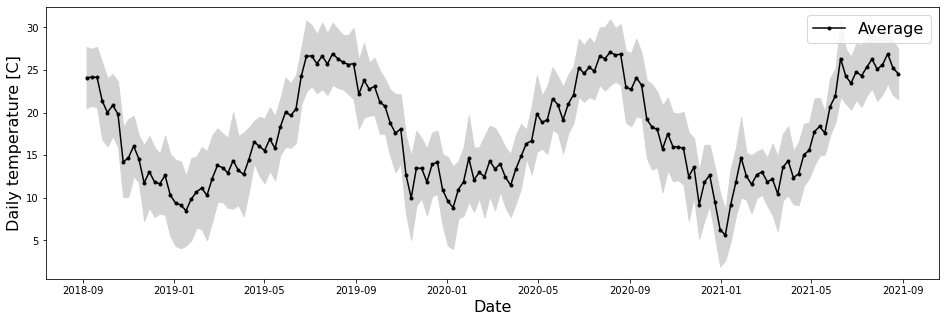

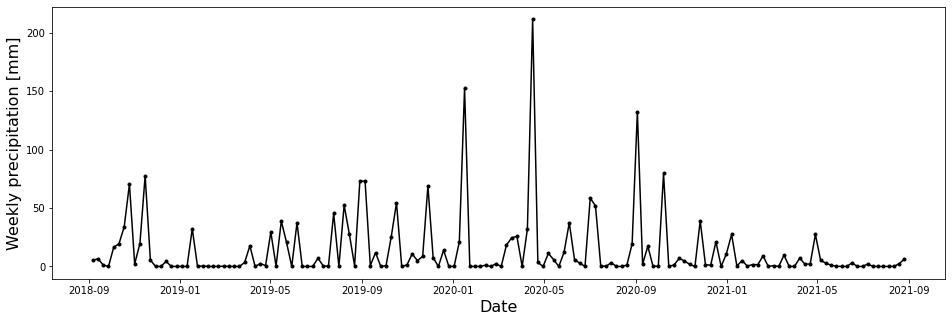

In [22]:
# Leave this code as-is

# Retrieve the past three years
weather_sample = weather_per_floating_week.tail(52*3)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Weekly precipitation [mm]")

Observing the weekly temperature plot, we see that the temperature is decreasing more gradually in autumn and increasing gradually in spring after applying the smoothing per floating week. Therefore, the data points appear more similar than in previous plots. In the weekly precipitation plot, we can see the peaks don't include over two weeks as storms usually don't last that long.

## 1.3. Smooth the series by binning per month

In [23]:
#Create the function list_of_month_starts that return an array containing entries of the date of the first day of the month 
def list_of_month_starts(first, last):
    months = []
    
    #obtain the first of the first month
    date = first.replace(day=1)
    
    #Adding the first month in the list
    months.append(date)
    
    while date < last:
        #Adding the next month
        if date.month < 12:
            date = date.replace(month= date.month+1)
        
        #Adding the next month of the next year
        else:
            date = date.replace(year=date.year+1, month=1)
            
        months.append(date)
    return months
    

In [24]:
#Testing the function above

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 61 month starts
First month starts 2016-09-01, last month starts 2021-09-01


In [25]:
# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start,month_start
date,,,,,,,,,,,,
2016-09-01,27.2,0.0,22.9,31.5,24.0,4.2,8.3,10.0,1021.9,1020.1,2016-09-01,2016-09-01
2016-09-02,25.7,0.0,22.2,29.2,23.0,5.3,11.7,9.9,1021.3,1018.0,2016-09-01,2016-09-01
2016-09-03,26.2,0.0,22.9,29.6,24.0,5.8,12.8,10.1,1020.0,1017.0,2016-09-01,2016-09-01
2016-09-04,26.5,0.0,22.9,30.1,99.0,4.4,10.8,8.2,1018.3,1016.1,2016-09-01,2016-09-01
2016-09-05,27.9,0.0,24.2,31.6,19.0,3.1,6.7,10.5,1018.8,1016.9,2016-09-01,2016-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,26.8,0.0,23.7,29.9,7.0,3.1,9.7,10.0,1012.7,1010.1,2021-08-26,2021-08-01
2021-08-28,24.9,0.0,22.6,27.2,11.0,4.7,9.2,5.7,1014.6,1009.9,2021-08-26,2021-08-01
2021-08-29,24.8,0.0,22.4,27.3,99.0,3.9,9.2,7.4,1014.5,1012.6,2021-08-26,2021-08-01


In [26]:
#Create a new dataframe with averages of temperature and the total of rainfall per month
weather_per_month= weather_with_month_start.groupby(['month_start']).agg({'temp_avg':"mean", 'temp_min': "mean",'temp_max':"mean","rainfall":"sum" })

#Print the first rows of the nwe dataframe
weather_per_month.head(10)

,temp_avg,temp_min,temp_max,rainfall
month_start,,,,
2016-09-01,23.426667,19.363333,27.476667,37.1
2016-10-01,18.906452,15.712903,22.109677,96.4
2016-11-01,14.283333,10.186667,18.356667,77.8
2016-12-01,11.551613,7.093548,16.006452,22.2
2017-01-01,9.010000,4.853333,13.170000,34.6
2017-02-01,12.521429,8.760714,16.278571,28.3
2017-03-01,13.723333,9.450000,18.016667,84.0
2017-04-01,14.713333,10.560000,18.850000,41.9
2017-05-01,19.356667,15.553333,23.173333,15.5


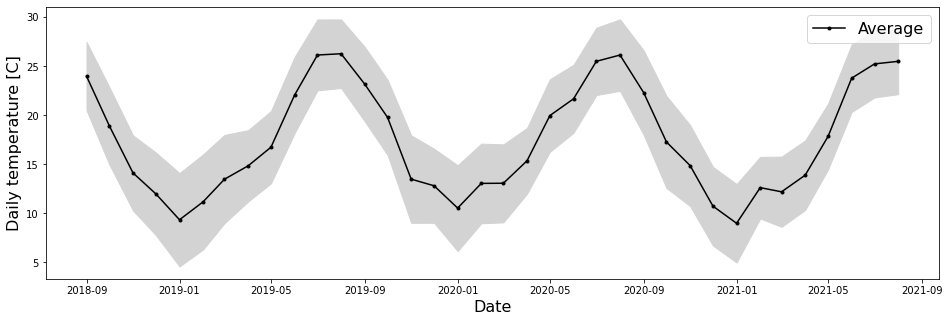

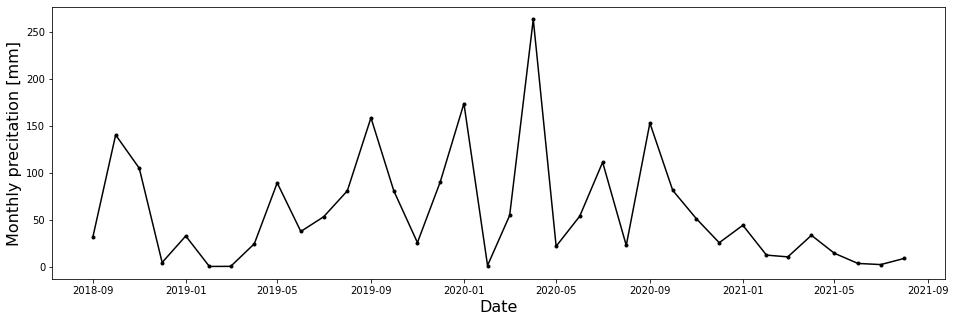

In [27]:
# Retrieve the last 3 years
weather_sample = weather_per_month.tail(3*12)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Monthly precitation [mm]")

In the graph above, we see how temperatures start decreasing in September and decrease until January. Following that, it starts to increase between February and July. We can observe from the monthly precipitation that April is the month with the greatest amount of precipitations, followed closely by January and September. However, July and August do not accumulate much precipitation.

# 2. Perform forecasting

## 2.1. Compute auto-correlation plots

In [28]:
#Compute the funcion lagged_series
def lagged_series(series, lag):
    original = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        
        if j in range(len(series)-1):
            #append series[i] to orginal
            original.append(series[i])
            
            #append series[j] to lagged
            lagged.append(series[j])
            
    return original, lagged

In [29]:
# Test the funcion above

lagged_series([11,22,33,44,55,66,77,88], 3)

([44, 55, 66, 77, 88], [11, 22, 33, 44, 55])

In [30]:
# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

In [31]:
#Create the function compute_autocorrelations that returns all the auto-correlations of a series from period 0 to max_periods-1
def compute_autocorrelations(series, max_periods):
    correlations = []
    
    #compute the auto-correlations from 0 to max_periods -1
    for i in range(max_periods):
        
        #adding autocorrelations in the array 
        correlations.append(autocorrelation(series, i))
        
    return correlations

In [32]:
#define max periods of 2 years
max_periods = 2*365

#create an array containing the correlations of the temperature average
auto_correlations_temp = compute_autocorrelations(weather['temp_avg'], max_periods)

#create an array containing the correlations of the rainfall
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'], max_periods)

In [33]:
# Leave this code as-is

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

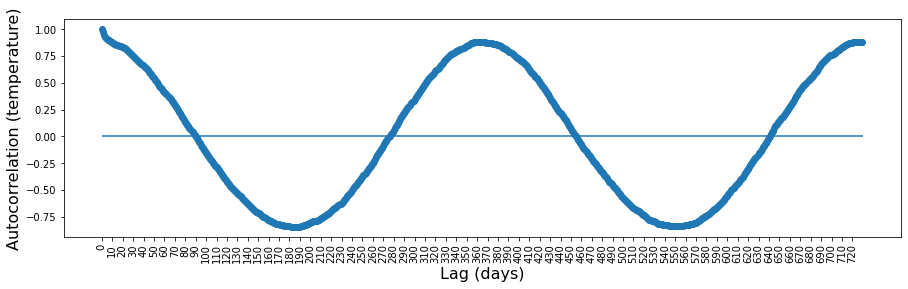

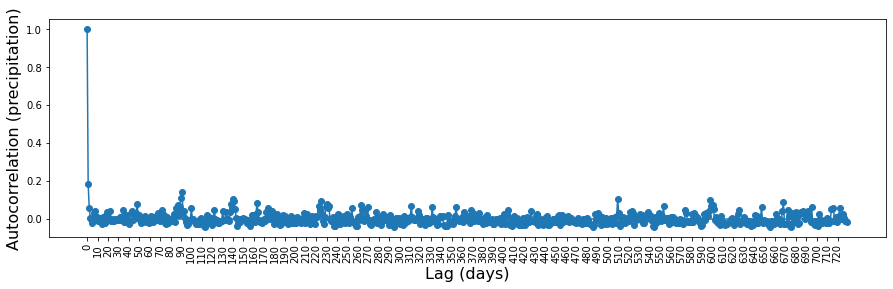

In [34]:
# Plot temperature auto-correlation
plot_auto_correlations(auto_correlations_temp, ylabel="Autocorrelation (temperature)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

As we can see from the temperature case, the autocorrelation is near 1 when a lag of 365 is used. As a result, lag values near 365 and lag values near 0 tend to have very high autocorrelations, which means the difference between close days is very small. There is also an high degree of negative autocorrelation near 180 lag value since the winter months are being compared with the summer months, six months in the future. It is therefore evident that the magnitude is seasonal.

When we examine precipitation, we see that all autocorrelations are close to zero. Therefore, precipitation has no seasonality because the data is not lag-valued and the autocorrelation level is high; this makes sense since precipitations in the real world are random.

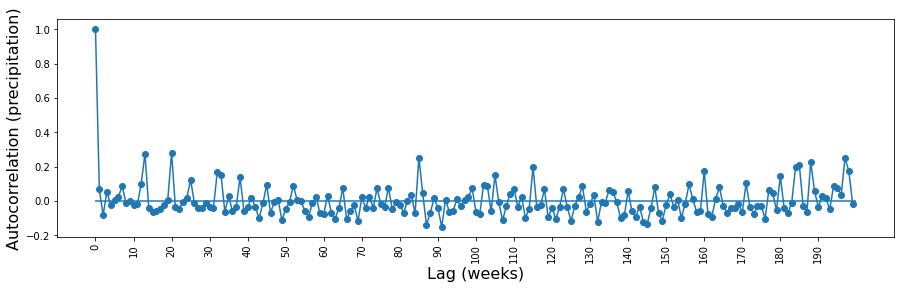

In [35]:
# Leave this code as-is

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

In any case, I consider these correlations to be random and unfounded, and they do not explain any real phenomenon.

## 2.2. Prepare a system of equations to learn an auto-regressive model

In [36]:
#Create the function prepare_matrices
def prepare_matrices(series, lags):
    y = []
    X = []

    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
    

    for i in range(np.max(lags), len(series)):
        #creating the new row
        row = [series[i-np.min(lags)],series[i-np.max(lags)]] 
        
        #deleting all equations that contains nan values
        if not (pd.isnull(series[i]) or pd.isnull(row[0]) or pd.isnull(row[1])):
            X.append(row)
            y.append(series[i])

    return X, y


In [37]:
# Testing the function above

X, y = prepare_matrices([11, 19, 32, 38, 51, 58, 69, 81], [2, 3,5])
print("X=%s" % X)
print("y=%s" % y)

X=[[38, 11], [51, 19], [58, 32]]
y=[58, 69, 81]


In [38]:
# Testing th function above

X, y = prepare_matrices([11, 19, 32, np.nan, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32, 19], [58, 51]]
y=[51, 81]


## 2.3. Perform forecasts

In [39]:
#Create the function perform_forecast

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='blue', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

In [40]:
#choose 4 months 
lags_monthly_temperature = [6,12,18,24]

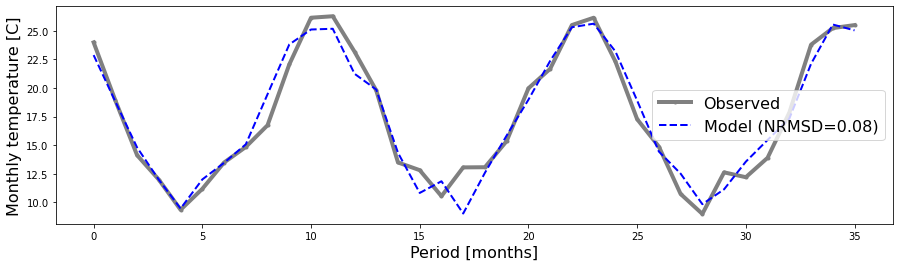

In [41]:
# predicting monthly temperature

(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly temperature [C]", nrmsd=nrmsd)

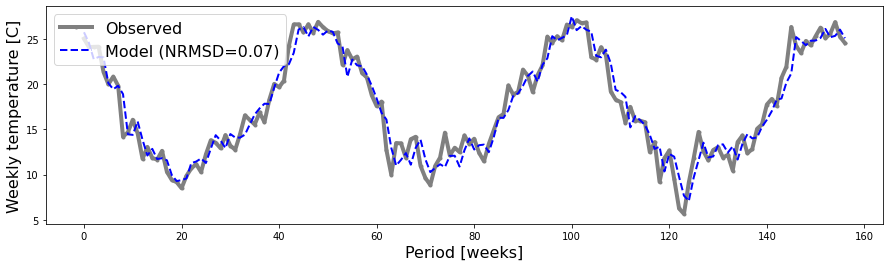

In [42]:
#predicting weekly temperature
lags_weekly_temperature = [1,26,52,104]
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['temp_avg'], lags_weekly_temperature)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly temperature [C]", nrmsd=nrmsd)

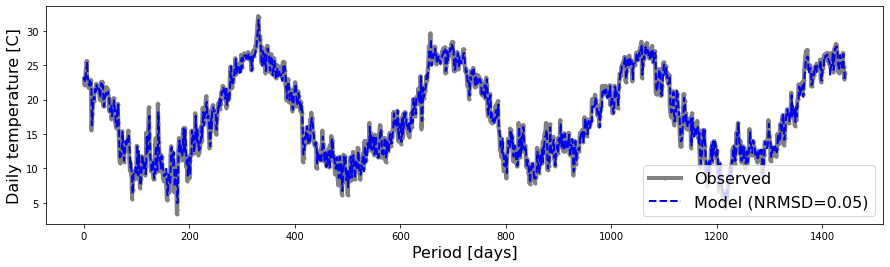

In [43]:
#predicting daily temperature
lags_daily_temperature = [1,2,364,365] 
(y, y_pred, nrmsd) = perform_forecast(weather['temp_avg'], lags_daily_temperature)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd)

Since the daily temperature series have seasonality, the model error is quite small (NRMSD). The best model is the one that uses the daily temperatures. This makes sense because the other datasets have lost the level of detail and information.

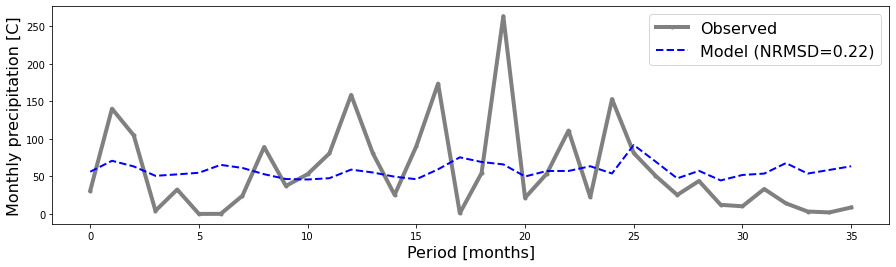

In [44]:
#predicting monthly rainfall
lags_monthly_rainfall = [6,12,18,24]
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['rainfall'], lags_monthly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly precipitation [C]", nrmsd=nrmsd)

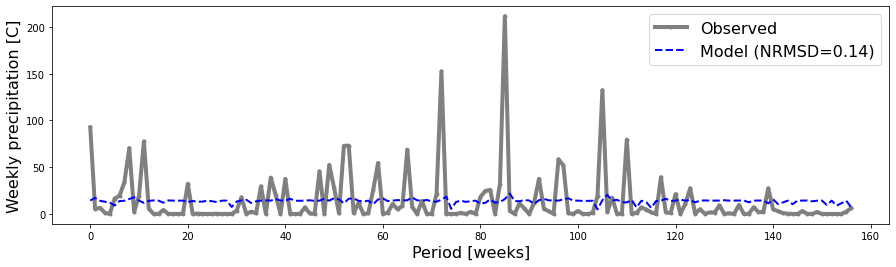

In [45]:
#predicting weekly rainfall
lags_weekly_rainfall = [1,26,52,104]
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['rainfall'], lags_weekly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly precipitation [C]", nrmsd=nrmsd)

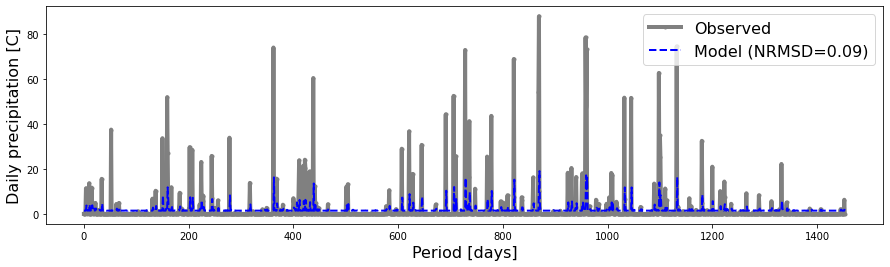

In [46]:
#predicting daily rainfall
lags_daily_rainfall = [1,2,360]
(y, y_pred, nrmsd) = perform_forecast(weather['rainfall'], lags_daily_rainfall)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily precipitation [C]", nrmsd=nrmsd)

Precipitation has a larger NRMSD in part because it does not have seasonality. While there may be some months with more precipitation, the quantity can differ greatly each year. Therefore, the best model is the one that uses the daily precipitations.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>